In [31]:
# packages ----------------------------------------------------------------
defaultW <- getOption("warn") 
options(warn = -1) 

install.packages('lubridate')
install.packages('dplyr')
install.packages('ggplot2')
install.packages('scales')
install.packages('plyr')
install.packages("arulesViz")
install.packages("arules")


library(lubridate)
library(dplyr)
library(scales)
library(ggplot2)
library(plyr)
library(arulesViz)
library(arules)



In [32]:
# funkcje -----------------------------------------------------------------

'%!in%' <- function(x, y)
  ! ('%in%'(x, y))



In [33]:
# import data -------------------------------------------------------------


path <- 'D:\\Informatyka i ekonometria\\SGH'
setwd(path)
file_names <-
  c(
    'olist_customers_dataset',
    'olist_order_items_dataset',
    'olist_order_payments_dataset',
    'olist_order_reviews_dataset',
    'olist_orders_dataset',
    'olist_products_dataset',
    'olist_sellers_dataset',
    'product_category_name_translation'
  )

for (i in 1:length(file_names))
{
  assign(paste0(file_names[i]), read.csv(
    paste0(file_names[i], '.csv'),
    na.strings = c('unknown', '', 'not_defined')
  ))
}


In [34]:
# usuwanie brakow danych ---------------------------------------------------------------

olist_customers_dataset <-
  olist_customers_dataset[complete.cases(olist_customers_dataset[c("customer_id", "customer_unique_id")]),]
olist_order_items_dataset <-
  olist_order_items_dataset[complete.cases(olist_order_items_dataset[c('order_id', 'order_item_id', 'product_id', 'seller_id')]),]
olist_order_payments_dataset <-
  olist_order_payments_dataset[complete.cases(olist_order_payments_dataset['order_id']),]
olist_order_reviews_dataset <-
  olist_order_reviews_dataset[complete.cases(olist_order_reviews_dataset[c('review_id', 'order_id')]),]
olist_orders_dataset <-
  olist_orders_dataset[complete.cases(olist_orders_dataset[c("order_id", "customer_id")]),]
olist_products_dataset <-
  olist_products_dataset[complete.cases(olist_products_dataset['product_id']),]
olist_sellers_dataset <-
  olist_sellers_dataset[complete.cases(olist_sellers_dataset['seller_id']),]


product_category_name_translation[10, 2] <- "alimentos_bebidas"
product_category_name_translation[17, 2] <-
  "fashion_bolsas_e_acessorios"
product_category_name_translation[46, 2] <- "livros_interesse_geral"
product_category_name_translation[63, 2] <- "flores"

product_category_name_translation[3, 3] <- "automotive"
product_category_name_translation[13, 3] <-
  "tablets_impression_image"
product_category_name_translation[40, 3] <- "living room furniture"
product_category_name_translation[53, 3] <- "fashion_womens_clothes"
product_category_name_translation[58, 3] <- "kitchen"
a = c(67, "telefonia", "telephony")
b = c(68,
      "construcao_ferramentas_construcao",
      "construction_tools_construction")
c = c(69, "climatizacao", "air_conditioning")
d = c(70, "musica", "music")
e = c(71, "pc_gamer", "pc_gamer")
f = c(
  72,
  "portateis_cozinha_e_preparadores_de_alimentos",
  "kitchen_laptops_food_preparers"
)
product_category_name_translation <-
  rbind(product_category_name_translation, a, b, c, d, e, f)
product_category_name_translation$X <-
  as.integer(product_category_name_translation$X)


In [35]:
# formatowanie danych ----------------------------------------------------------


olist_order_items_dataset$shipping_limit_date <-
  as.POSIXlt(olist_order_items_dataset$shipping_limit_date)

olist_order_reviews_dataset$review_creation_date <-
  as.POSIXlt(olist_order_reviews_dataset$review_creation_date)
olist_order_reviews_dataset$review_answer_timestamp <-
  as.POSIXlt(olist_order_reviews_dataset$review_answer_timestamp)


olist_orders_dataset$order_purchase_timestamp <-
  as.POSIXct(olist_orders_dataset$order_purchase_timestamp)
olist_orders_dataset$order_approved_at <-
  as.POSIXlt(olist_orders_dataset$order_approved_at)
olist_orders_dataset$order_delivered_carrier_date <-
  as.POSIXlt(olist_orders_dataset$order_delivered_carrier_date)
olist_orders_dataset$order_delivered_customer_date <-
  as.POSIXlt(olist_orders_dataset$order_delivered_customer_date)
olist_orders_dataset$order_estimated_delivery_date <-
  as.POSIXlt(olist_orders_dataset$order_estimated_delivery_date)



In [36]:
# laczenie danych ---------------------------------------------------------

x <-
  olist_order_items_dataset %>% left_join(olist_orders_dataset, by = 'order_id')
y <- x %>% left_join(olist_products_dataset, by = 'product_id')
y <-
  y %>% left_join(product_category_name_translation, by = 'product_category_name')

y <- y[!is.na(y$product_category_name_english), ]

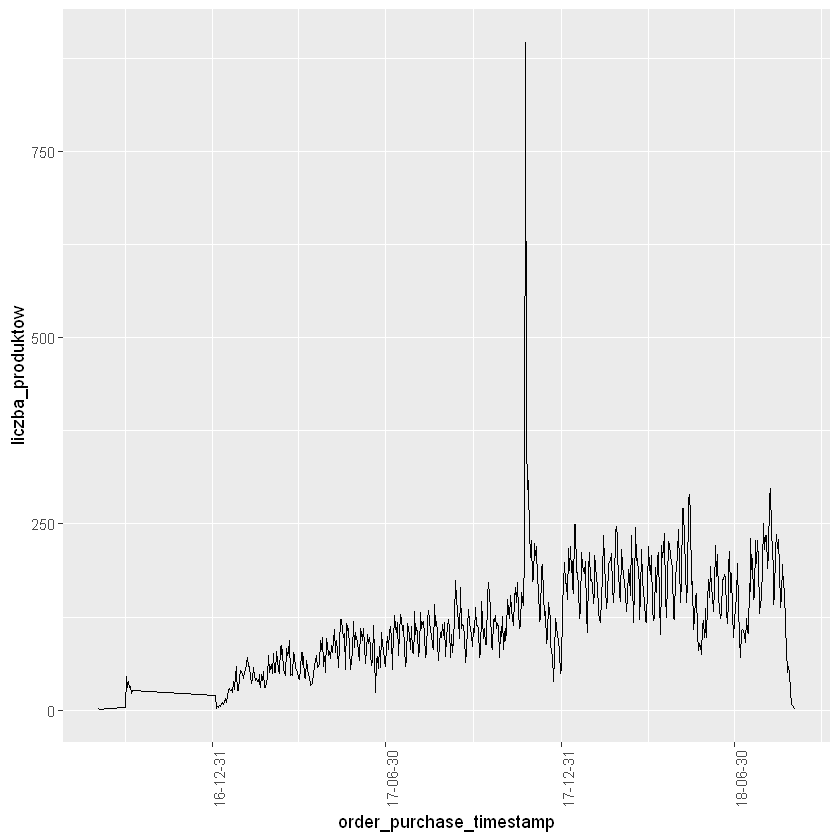

In [37]:
# szereg czasowy zakupionych produktow ------------------------------------

szereg_czasowy_produktow <-
  y %>% group_by(order_purchase_timestamp) %>% dplyr::summarise(liczba_produktow = n())
szereg_czasowy_produktow <-  na.omit(szereg_czasowy_produktow)
szereg_czasowy_produktow %>%
  ggplot(aes(order_purchase_timestamp, liczba_produktow)) +
  geom_line() +
  theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
  scale_x_datetime(labels = date_format("%y-%m-%d"))


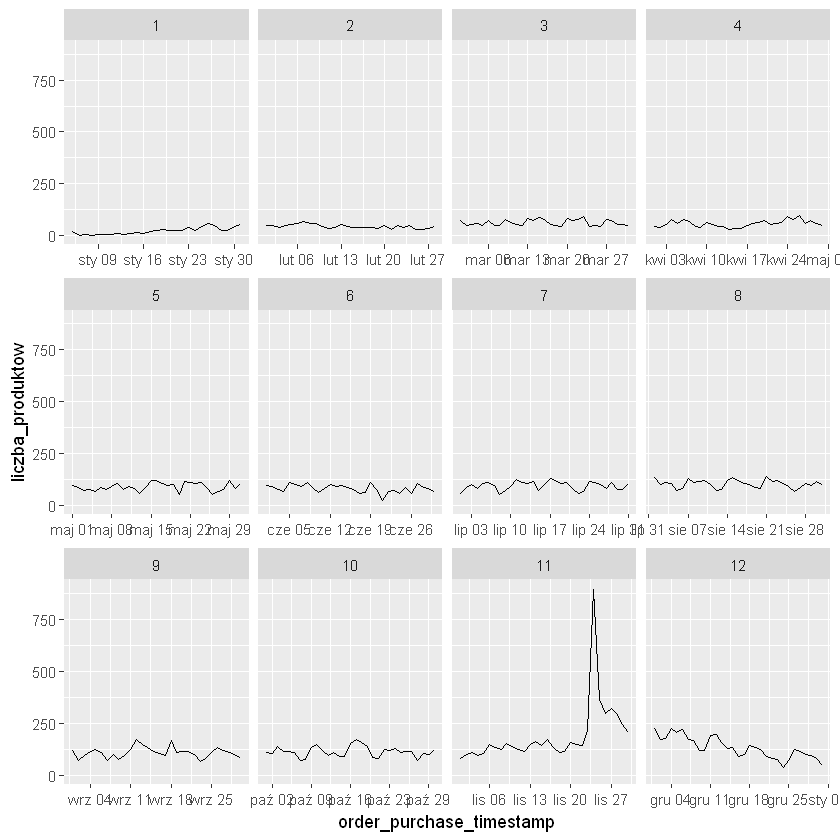

In [38]:
# szereg czasowy miesiecznej sprzedazy w 2017 ------------------------------------

y %>% filter(year(order_purchase_timestamp) == 2017) %>% group_by(order_purchase_timestamp) %>%
  dplyr::summarise(liczba_produktow = n()) %>%
  ggplot(aes(order_purchase_timestamp, liczba_produktow)) + geom_line() +
  facet_wrap(~ month(order_purchase_timestamp), scales = "free_x")

In [39]:
# TOP 10 produktow ------------------------------------------------------------------

s <- y %>%
  filter(!is.na(product_category_name_english)) %>%
  group_by(product_category_name_english) %>%
  dplyr::summarise(liczba_sprzedazy = n()) %>% arrange(desc(liczba_sprzedazy)) %>%
  top_n(liczba_sprzedazy, n = 10)


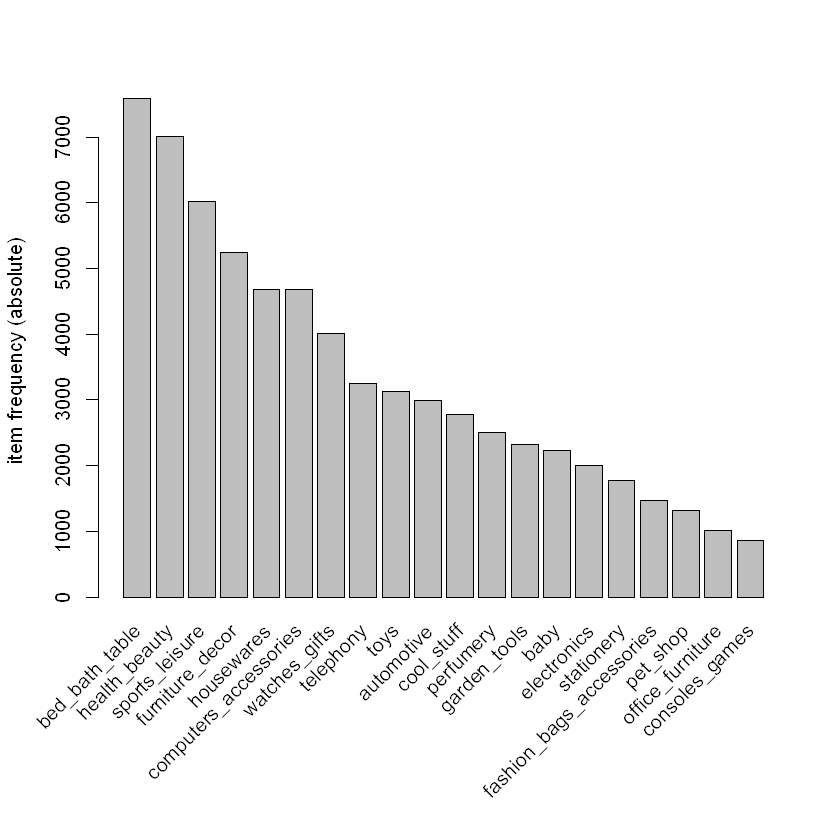

In [40]:
# analiza koszykowa -----------------------------------------------------------------
defaultW <- getOption("warn") 
options(warn = -1) 


u <- y[, c("order_id", "product_category_name_english")]
itemList <-
  ddply(u, c("order_id"), function(df1)
    paste(df1$product_category_name_english, collapse = ","))

itemList$order_id <- NULL
colnames(itemList) <- c("items")
write.csv(itemList,
          file = "market_basket.csv",
          row.names = F,
          quote = F)


tr = read.transactions("market_basket.csv", format = "basket", sep = ",")

itemFrequencyPlot(tr, topN = 20, type = "absolute")


Apriori

Parameter specification:
 confidence minval smax arem  aval originalSupport maxtime support minlen
      1e-04    0.1    1 none FALSE            TRUE       5   1e-05      1
 maxlen target  ext
     10  rules TRUE

Algorithmic control:
 filter tree heap memopt load sort verbose
    0.1 TRUE TRUE  FALSE TRUE    2    TRUE

Absolute minimum support count: 0 

set item appearances ...[0 item(s)] done [0.00s].
set transactions ...[74 item(s), 75432 transaction(s)] done [0.01s].
sorting and recoding items ... [74 item(s)] done [0.00s].
creating transaction tree ... done [0.01s].
checking subsets of size 1 2 3 done [0.00s].
writing ... [466 rule(s)] done [0.00s].
creating S4 object  ... done [0.00s].


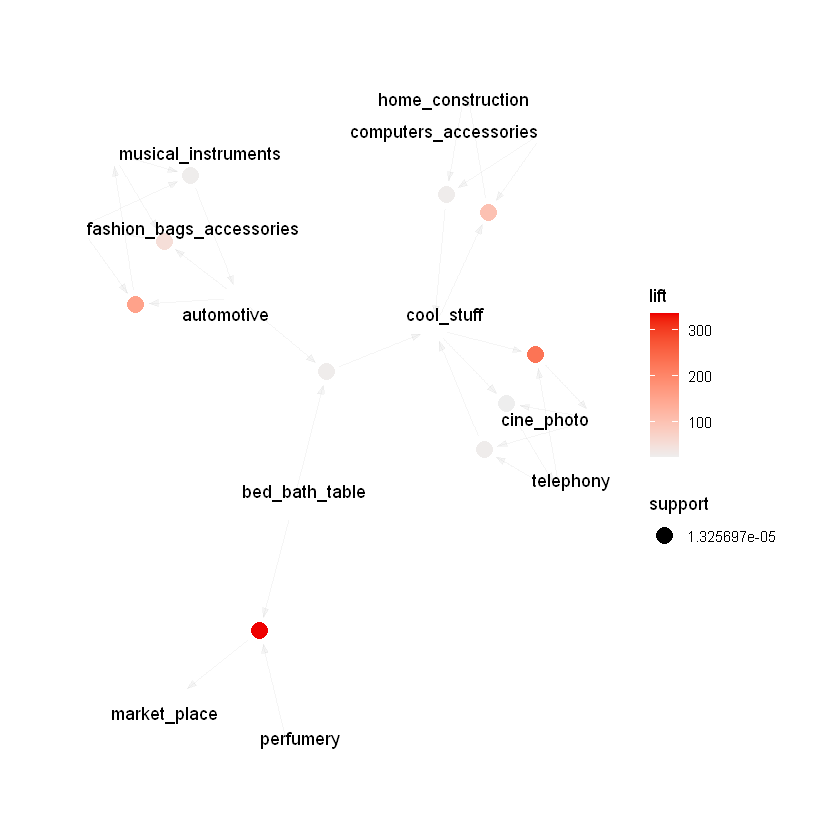

In [42]:

# algorytm a priori -------------------------------------------------------
rules = apriori(tr
                , parameter = list(
                  supp = 0.00001,
                  conf = 0.0001,
                  target = "rules"
                ))
plot(head(sort(rules, by = "lift"), 10),
     method = "graph")

     lhs                            rhs                             support confidence     coverage       lift count
[1]  {cine_photo,                                                                                                   
      cool_stuff}                => {telephony}                1.325697e-05  1.0000000 1.325697e-05  23.195572     1
[2]  {cine_photo,                                                                                                   
      telephony}                 => {cool_stuff}               1.325697e-05  1.0000000 1.325697e-05  27.202308     1
[3]  {market_place,                                                                                                 
      perfumery}                 => {bed_bath_table}           1.325697e-05  1.0000000 1.325697e-05   9.940959     1
[4]  {bed_bath_table,                                                                                               
      perfumery}                 => {market_place}             1

NULL

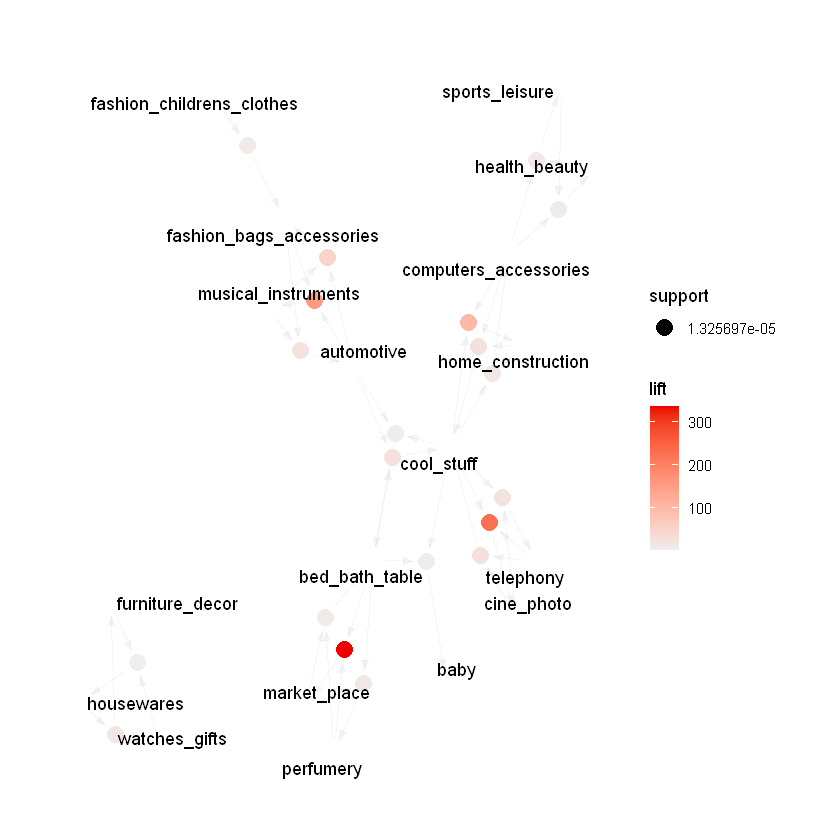

In [19]:
topRules = sort(rules, by = "confidence")[1:20]

head(inspect(topRules))

plot(topRules, method = "graph")



In [43]:
df <- DATAFRAME(rules,
                separate = TRUE,
                setStart = "",
                setEnd = "")
o <- df[order(-df$count), ]

o <- df[df$LHS %!in% c(''), ]
head(o)

,LHS,RHS,support,confidence,coverage,lift,count
,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
72,fashion_childrens_clothes,fashion_bags_accessories,1.325697e-05,0.2000000000,6.628487e-05,10.262857,1
73,fashion_bags_accessories,fashion_childrens_clothes,1.325697e-05,0.0006802721,1.948775e-02,10.262857,1
74,pc_gamer,cool_stuff,1.325697e-05,0.1250000000,1.060558e-04,3.400288,1
75,cool_stuff,pc_gamer,1.325697e-05,0.0003606203,3.676159e-02,3.400288,1
76,fashion_sport,fashion_bags_accessories,1.325697e-05,0.0476190476,2.783964e-04,2.443537,1
77,fashion_bags_accessories,fashion_sport,1.325697e-05,0.0006802721,1.948775e-02,2.443537,1


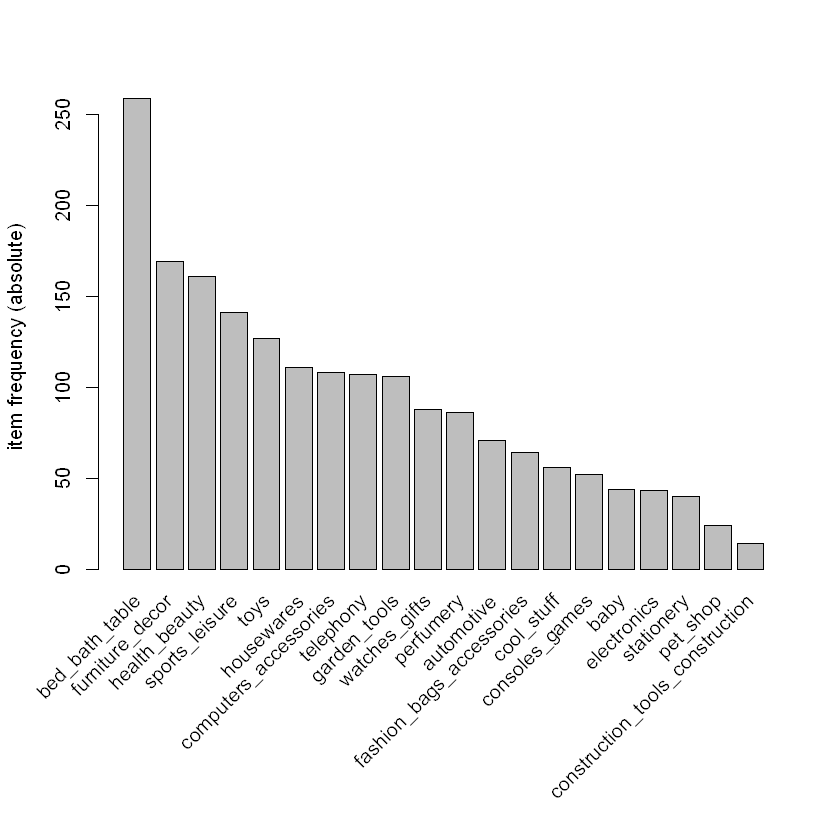

In [44]:
# dla black week ----------------------------------------------------------
defaultW <- getOption("warn") 
options(warn = -1) 


black_week <-
  y %>% filter(between(
    order_purchase_timestamp,
    as.POSIXct("2017-11-19"),
    as.POSIXct("2017-11-26")
  ))

u <- black_week[, c("order_id", "product_category_name_english")]

itemList <-
  ddply(u, c("order_id"), function(df1)
    paste(df1$product_category_name_english, collapse = ","))


itemList$order_id <- NULL
colnames(itemList) <- c("items")
write.csv(itemList,
          file = "black_week.csv",
          row.names = F,
          quote = F)

tr = read.transactions("black_week.csv", format = "basket", sep = ",")
itemFrequencyPlot(tr, topN = 20, type = "absolute")


Apriori

Parameter specification:
 confidence minval smax arem  aval originalSupport maxtime support minlen
      0.001    0.1    1 none FALSE            TRUE       5   1e-04      1
 maxlen target  ext
     10  rules TRUE

Algorithmic control:
 filter tree heap memopt load sort verbose
    0.1 TRUE TRUE  FALSE TRUE    2    TRUE

Absolute minimum support count: 0 

set item appearances ...[0 item(s)] done [0.00s].
set transactions ...[52 item(s), 2036 transaction(s)] done [0.00s].
sorting and recoding items ... [52 item(s)] done [0.00s].
creating transaction tree ... done [0.00s].
checking subsets of size 1 2 done [0.00s].
writing ... [57 rule(s)] done [0.00s].
creating S4 object  ... done [0.00s].


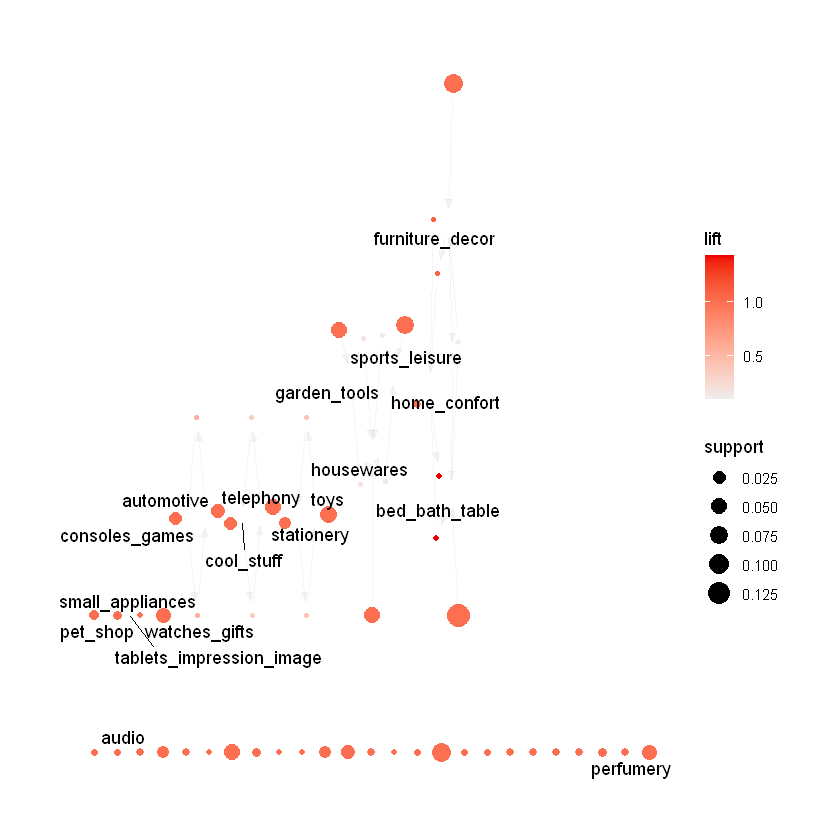

In [45]:
defaultW <- getOption("warn") 
options(warn = -1) 

rules = apriori(tr
                , parameter = list(
                  supp = 0.0001,
                  conf = 0.001,
                  target = "rules"
                ))
plot(sort(rules, by = "lift"),
     method = "graph")

In [46]:
topRules = sort(rules, by = "confidence")[1:20]

inspect(topRules)


     lhs               rhs                        support      confidence
[1]  {home_confort} => {bed_bath_table}           0.0009823183 0.18181818
[2]  {}             => {bed_bath_table}           0.1272102161 0.12721022
[3]  {home_confort} => {furniture_decor}          0.0004911591 0.09090909
[4]  {}             => {furniture_decor}          0.0830058939 0.08300589
[5]  {}             => {health_beauty}            0.0790766208 0.07907662
[6]  {}             => {sports_leisure}           0.0692534381 0.06925344
[7]  {}             => {toys}                     0.0623772102 0.06237721
[8]  {}             => {housewares}               0.0545186640 0.05451866
[9]  {}             => {computers_accessories}    0.0530451866 0.05304519
[10] {}             => {telephony}                0.0525540275 0.05255403
[11] {}             => {garden_tools}             0.0520628684 0.05206287
[12] {}             => {watches_gifts}            0.0432220039 0.04322200
[13] {}             => {perfumery}    

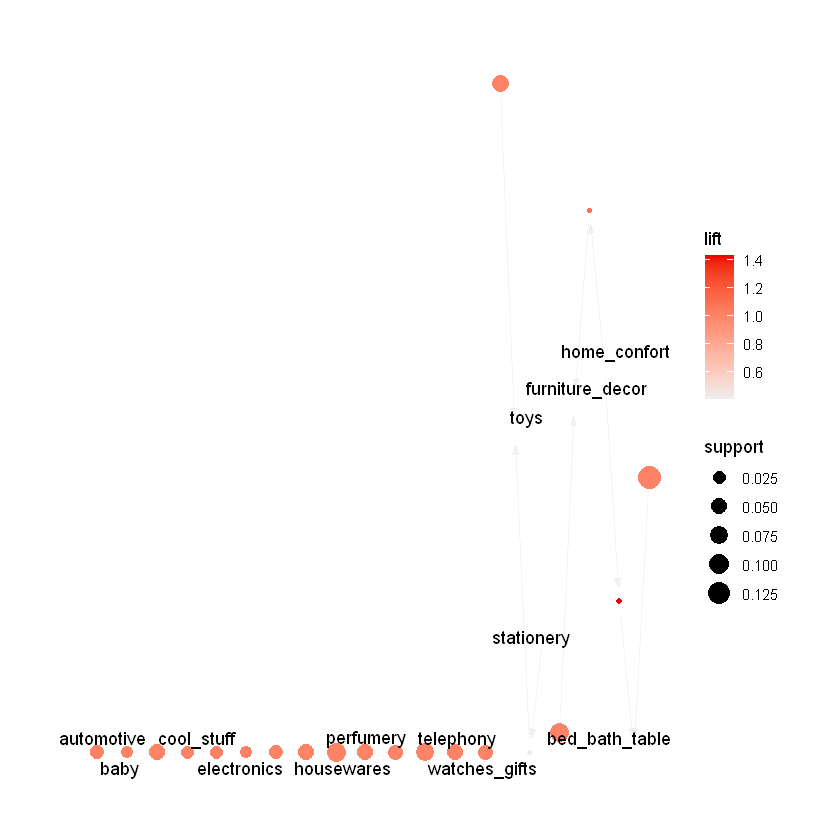

In [47]:
plot(topRules, method = "graph")

In [48]:
inspect(rules)
df <- DATAFRAME(rules,
                separate = TRUE,
                setStart = "",
                setEnd = "")
bw <- df[order(-df$count), ]

bw <- df[df$LHS %!in% c(''), ]

     lhs                  rhs                                      
[1]  {}                => {books_technical}                        
[2]  {}                => {construction_tools_lights}              
[3]  {}                => {food}                                   
[4]  {}                => {construction_tools_safety}              
[5]  {}                => {tablets_impression_image}               
[6]  {}                => {agro_industry_and_commerce}             
[7]  {}                => {home_appliances_2}                      
[8]  {}                => {home_appliances}                        
[9]  {}                => {air_conditioning}                       
[10] {}                => {food_drink}                             
[11] {}                => {fashion_shoes}                          
[12] {}                => {books_general_interest}                 
[13] {}                => {office_furniture}                       
[14] {}                => {home_construction}   

In [49]:
head(bw)

,LHS,RHS,support,confidence,coverage,lift,count
,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
42,home_confort,furniture_decor,0.0004911591,0.090909091,0.00540275,1.0952125,1
43,furniture_decor,home_confort,0.0004911591,0.005917160,0.08300589,1.0952125,1
44,home_confort,bed_bath_table,0.0009823183,0.181818182,0.00540275,1.4292734,2
45,bed_bath_table,home_confort,0.0009823183,0.007722008,0.12721022,1.4292734,2
46,stationery,toys,0.0004911591,0.025000000,0.01964637,0.4007874,1
47,toys,stationery,0.0004911591,0.007874016,0.06237721,0.4007874,1
